In [1]:

import joblib, numpy as np, pandas as pd
import shap, matplotlib.pyplot as plt
from pathlib import Path

## Hospital Performance Simulator
### Core function for TPS prediction, probability assessment, and explainability

In [2]:

MODEL_DIR = Path("../models")
linr = joblib.load(MODEL_DIR / "tps_linear.pkl")          
xgb  = joblib.load(MODEL_DIR / "tps_topquartile_xgb.pkl")
explainer = shap.TreeExplainer(xgb)

def simulate(*, clinical, pce, safety, efficiency, explain=True):
    """
    Simulate hospital performance predictions based on domain scores.
    
    This function predicts a hospital's Total Performance Score (TPS) and probability 
    of achieving top-quartile status (top 25% of performers) based on their weighted 
    domain scores. Optionally generates SHAP explanations for model interpretability.
    
    Parameters
    ----------
    clinical : float or None
        Weighted Clinical Outcomes Domain Score (0-33.3 typical range)
    pce : float or None  
        Weighted Person & Community Engagement Domain Score (0-33.3 typical range)
    safety : float or None
        Weighted Safety Domain Score (0-33.3 typical range)
        Pass None for hospitals without safety data (gets filled with 0)
    efficiency : float or None
        Weighted Efficiency & Cost Reduction Domain Score (0-33.3 typical range)
    explain : bool, default=True
        Whether to generate SHAP waterfall explanation plot
        
    Returns
    -------
    dict
        Dictionary containing:
        - 'tps' : float
            Predicted Total Performance Score (rounded to 2 decimals)
        - 'top_q_prob' : float  
            Probability of top-quartile performance (0-1, rounded to 3 decimals)
        - 'shap_values' : np.ndarray (if explain=True)
            SHAP values showing feature contributions
        - 'waterfall_fig' : matplotlib.figure.Figure (if explain=True)
            SHAP waterfall plot explaining the prediction
    """
    row = {
        "wt_clinical":   clinical or 0.0,
        "wt_pce":        pce       or 0.0,
        "wt_safety":     safety if safety is not None else np.nan,
        "wt_efficiency": efficiency or 0.0,
    }
    X = pd.DataFrame([row])
    
    # --- TPS via linear clone
    tps = float(linr.predict(X.fillna(0))[0])
    
    # --- Top-quartile probability via XGB
    prob = float(xgb.predict_proba(X.fillna(0))[0, 1])
    
    result = {"tps": round(tps, 2), "top_q_prob": round(prob, 3)}
    
    if explain:
        sv = explainer.shap_values(X.fillna(0))[0]
        result["shap_values"] = sv
        
        
        base = explainer.expected_value
        fnames = ["Clinical", "PCE", "Safety", "Efficiency"]
        
        # Create a new figure for the waterfall
        fig, ax = plt.subplots(figsize=(10, 6))
        plt.sca(ax)
        
        shap.waterfall_plot(
            shap.Explanation(values=sv,
                           base_values=base,
                           data=X.fillna(0).values[0],
                           feature_names=fnames),
            show=False
        )
        plt.tight_layout()
        result["waterfall_fig"] = fig
    
    return result


## Demo: Single Hospital Simulation
### Test the simulator with example hospital scores

{'tps': 41.7,
 'top_q_prob': 0.999,
 'shap_values': array([ 0.92044026,  1.810669  , -2.6226919 ,  6.7574835 ], dtype=float32),
 'waterfall_fig': <Figure size 800x350 with 3 Axes>}

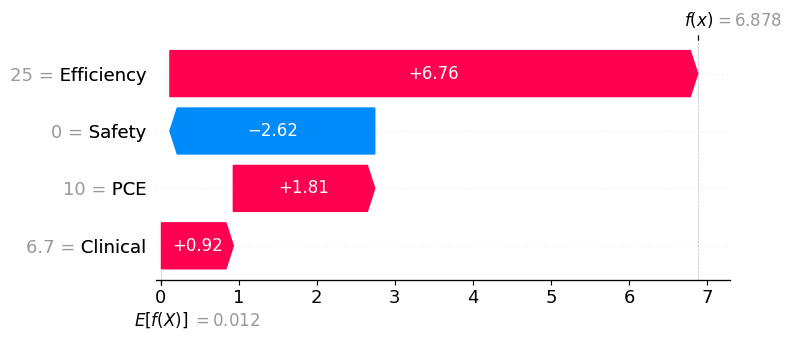

In [3]:
baseline = simulate(clinical=6.7, pce=10, safety=None, efficiency=25)
baseline


## Interactive  Dashboard
### Real-time scenario testing with adjustable sliders

In [5]:
import ipywidgets as wd
from IPython.display import display, clear_output


s_clin = wd.FloatSlider(description="Clinical",   min=0, max=33.3, step=0.1, value=6.7)
s_pce  = wd.FloatSlider(description="PCE",        min=0, max=33.3, step=0.1, value=10)
s_safe = wd.FloatSlider(description="Safety",     min=0, max=33.3, step=0.1, value=0)
s_eff  = wd.FloatSlider(description="Efficiency", min=0, max=33.3, step=0.1, value=25)

out = wd.Output(layout={"border": "1px solid lightgrey"})

def update(_=None):

    """
    Update the interactive dashboard display when slider values change.
    
    This callback function is triggered whenever any slider value changes,
    recalculating the hospital performance predictions and updating the
    visual output in real-time.
    
    Parameters
    ----------
    _ : any, optional, default=None
        Placeholder parameter for slider change events. The actual slider
        values are accessed via the global slider objects (s_clin, s_pce, etc.)
        Jupyter widgets pass change information here, but we don't need it.
        
    Returns
    -------
    None
        Function updates the dashboard display in-place

    """
    
    with out:
        clear_output(wait=True)
        res = simulate(
            clinical=s_clin.value,
            pce=s_pce.value,
            safety=s_safe.value if s_safe.value > 0 else None,
            efficiency=s_eff.value
        )
        print(f"TPS: {res['tps']}   •   Top-quartile probability: {res['top_q_prob']:.2%}")
        res["waterfall_fig"]

for slider in (s_clin, s_pce, s_safe, s_eff):
    slider.observe(update, "value")

display(s_clin, s_pce, s_safe, s_eff, out)
update()               


FloatSlider(value=6.7, description='Clinical', max=33.3)

FloatSlider(value=10.0, description='PCE', max=33.3)

FloatSlider(value=0.0, description='Safety', max=33.3)

FloatSlider(value=25.0, description='Efficiency', max=33.3)

Output(layout=Layout(border_bottom='1px solid lightgrey', border_left='1px solid lightgrey', border_right='1px…

## Scenario Analysis
### Systematic evaluation of score combinations for optimal performance

In [29]:
import itertools, pandas as pd

# define value grids 
clinical_vals   = [0,  5, 10]      # weighted points
pce_vals        = [0, 10, 20]
safety_vals     = [None, 10, 20]   # None = "Not Available" as in the original dataset for some hospitals
efficiency_vals = [10, 20, 30]

grid = list(itertools.product(clinical_vals,
                              pce_vals,
                              safety_vals,
                              efficiency_vals))

# run simulate() over the cartesian grid 
rows = []
for clin, pce, saf, eff in grid:
    r = simulate(clinical=clin, pce=pce, safety=saf, efficiency=eff,
                 explain=True)        
    rows.append({
        "clinical": clin,
        "pce":      pce,
        "safety":   saf if saf is not None else "NA",
        "efficiency": eff,
        "TPS":        r["tps"],
        "TopQ_Prob":  r["top_q_prob"]
    })

scenario_df = pd.DataFrame(rows)

scenario_df = scenario_df.sort_values("TopQ_Prob", ascending=False).reset_index(drop=True)
scenario_df.head(15)           # display top 15 scenarios by probability


,clinical,pce,safety,efficiency,TPS,TopQ_Prob
0,0,0,20,30,50.0,1.0
1,0,10,20,20,50.0,1.0
2,10,20,20,10,60.0,1.0
3,10,20,20,20,70.0,1.0
4,10,20,10,20,60.0,1.0
5,10,20,20,30,80.0,1.0
6,10,0,20,30,60.0,1.0
7,10,0,20,20,50.0,1.0
8,10,0,20,10,40.0,1.0
9,5,0,20,30,55.0,1.0


## Export Individual Hospital Reports
### Generate SHAP waterfall explanations for specific facilities

In [31]:
import os, matplotlib.pyplot as plt
from pathlib import Path


fig_dir = Path("../figures/batch_waterfalls")
fig_dir.mkdir(exist_ok=True, parents=True)

df   = pd.read_parquet(Path("../data/processed/hvbp_2025_clean.parquet"))

sample_ids = [20006, 50137, 230241, 240006, 240043, 340187, 340190, 460057]


for fac in sample_ids:
    row = df[df["Facility ID"] == fac].iloc[0]

    res = simulate(clinical=row["wt_clinical"],
                   pce=row["wt_pce"],
                   safety=row["wt_safety"] if not pd.isna(row["wt_safety"]) else None,
                   efficiency=row["wt_efficiency"],
                   explain=True)

    # save figure
    fpath = fig_dir / f"waterfall_{fac}.png"
    res["waterfall_fig"].savefig(fpath, dpi=150)
    plt.close(res["waterfall_fig"])        
    print(f"Saved {fpath.name}  (TPS={res['tps']}, Prob={res['top_q_prob']:.2%})")


Saved waterfall_20006.png  (TPS=58.75, Prob=100.00%)
Saved waterfall_50137.png  (TPS=59.0, Prob=100.00%)
Saved waterfall_230241.png  (TPS=63.0, Prob=100.00%)
Saved waterfall_240006.png  (TPS=64.11, Prob=100.00%)
Saved waterfall_240043.png  (TPS=59.88, Prob=100.00%)
Saved waterfall_340187.png  (TPS=75.67, Prob=100.00%)
Saved waterfall_340190.png  (TPS=60.22, Prob=100.00%)
Saved waterfall_460057.png  (TPS=61.0, Prob=100.00%)
